In [124]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

In [125]:
df = pd.read_csv('train_intro.csv')
df.head()

,Unnamed: 0,Stock1,Stock2,Stock3,Stock4,Stock1_Delay,Stock2_Delay,Stock3_Delay,Stock4_Delay
0,0,1479.36,1088.26,1545.61,1304.27,1481.40,1094.60,1546.06,1347.49
1,1,1479.33,1087.03,1544.94,1305.82,1479.36,1088.26,1545.61,1304.27
2,2,1479.72,1087.16,1543.55,1287.43,1479.33,1087.03,1544.94,1305.82
3,3,1477.47,1077.92,1545.35,1193.67,1479.72,1087.16,1543.55,1287.43
4,4,1474.91,1076.45,1545.01,1296.92,1477.47,1077.92,1545.35,1193.67


In [126]:
# add returns columns for each stock
for stock in ['Stock1', 'Stock2', 'Stock3', 'Stock4', 'Stock1_Delay', 'Stock2_Delay', 'Stock3_Delay', 'Stock4_Delay']:
    df[stock + '_Return'] = df[stock].pct_change()


# # IMPORTANT: Shift non-delayed returns forward by 1 day (model the 1-delay)
""" df['Stock1_Return'] = df['Stock1_Return'].shift(-1)
df['Stock2_Return'] = df['Stock2_Return'].shift(-1)
df['Stock3_Return'] = df['Stock3_Return'].shift(-1)
df['Stock4_Return'] = df['Stock4_Return'].shift(-1) """

df.replace(np.nan, 0, inplace=True)

df.head()

,Unnamed: 0,Stock1,Stock2,Stock3,Stock4,Stock1_Delay,Stock2_Delay,Stock3_Delay,Stock4_Delay,Stock1_Return,Stock2_Return,Stock3_Return,Stock4_Return,Stock1_Delay_Return,Stock2_Delay_Return,Stock3_Delay_Return,Stock4_Delay_Return
0,0,1479.36,1088.26,1545.61,1304.27,1481.40,1094.60,1546.06,1347.49,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,1479.33,1087.03,1544.94,1305.82,1479.36,1088.26,1545.61,1304.27,-0.000020,-0.001130,-0.000433,0.001188,-0.001377,-0.005792,-0.000291,-0.032074
2,2,1479.72,1087.16,1543.55,1287.43,1479.33,1087.03,1544.94,1305.82,0.000264,0.000120,-0.000900,-0.014083,-0.000020,-0.001130,-0.000433,0.001188
3,3,1477.47,1077.92,1545.35,1193.67,1479.72,1087.16,1543.55,1287.43,-0.001521,-0.008499,0.001166,-0.072827,0.000264,0.000120,-0.000900,-0.014083
4,4,1474.91,1076.45,1545.01,1296.92,1477.47,1077.92,1545.35,1193.67,-0.001733,-0.001364,-0.000220,0.086498,-0.001521,-0.008499,0.001166,-0.072827


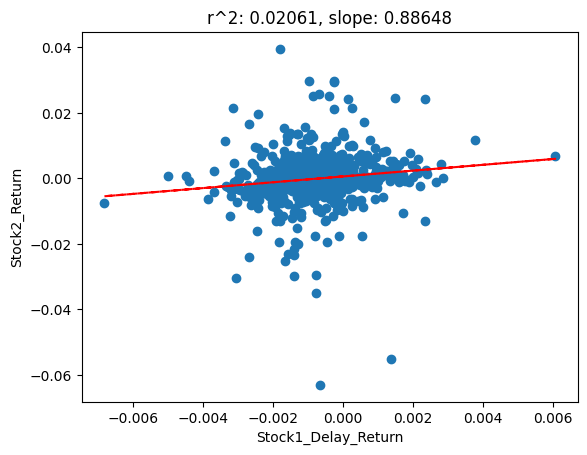

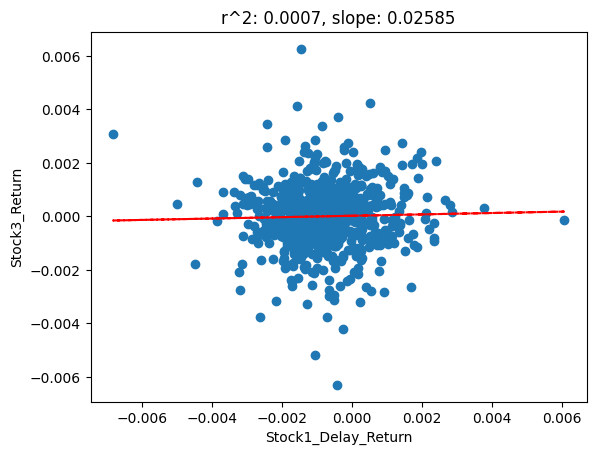

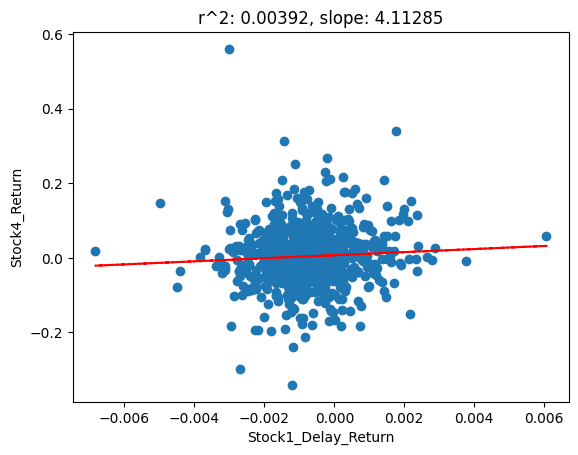

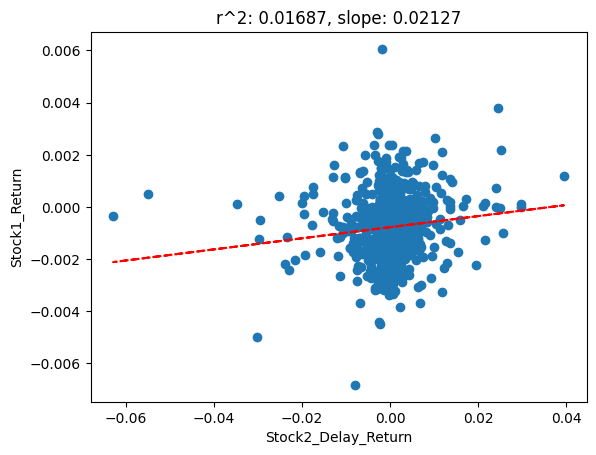

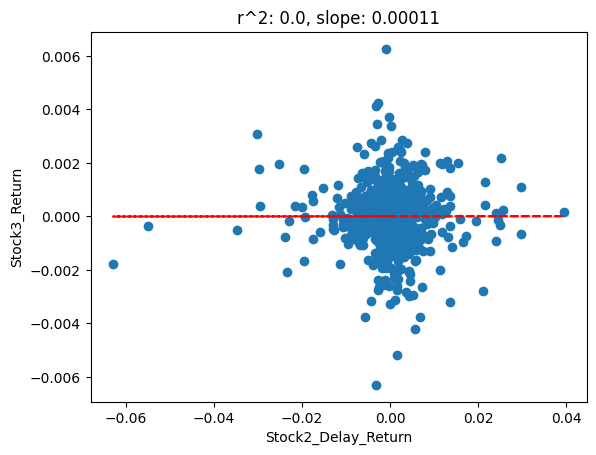

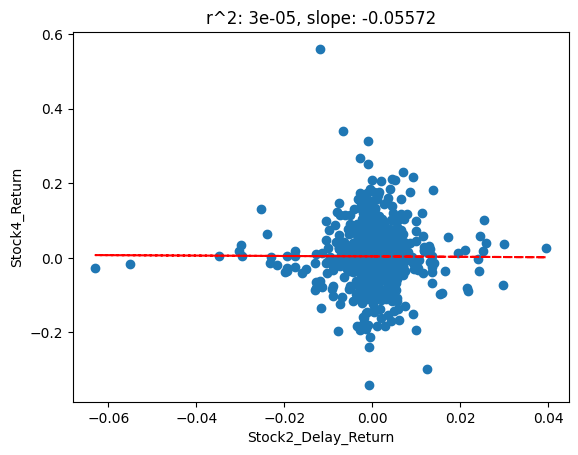

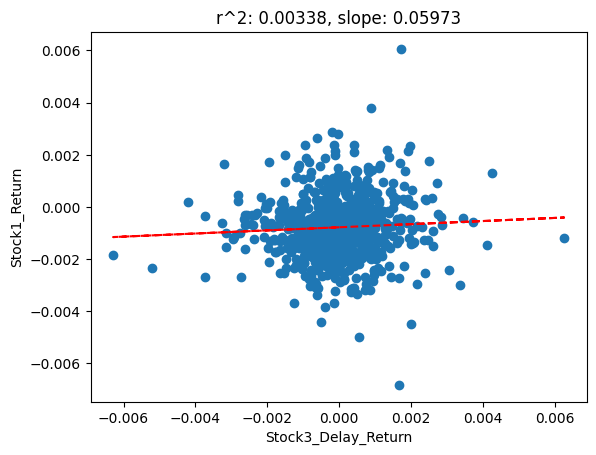

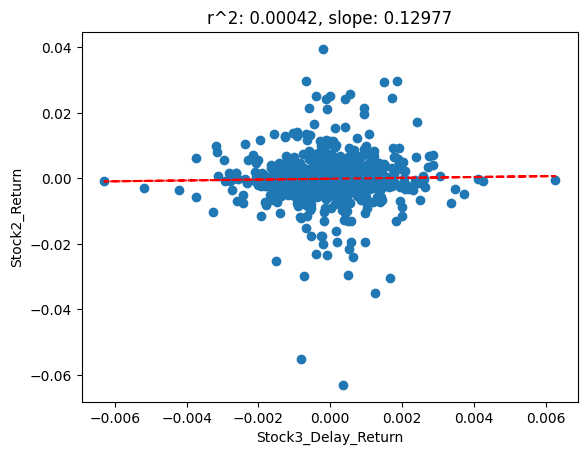

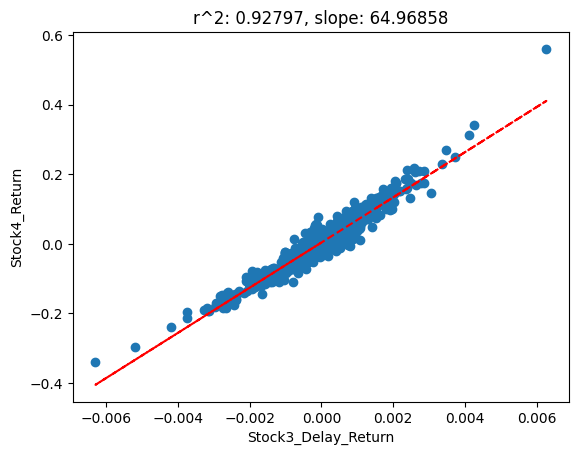

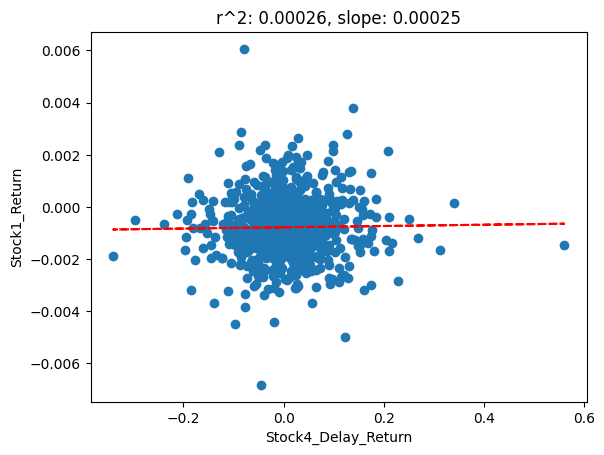

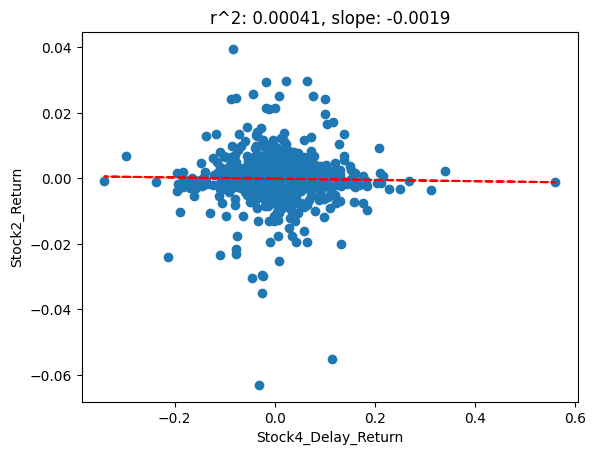

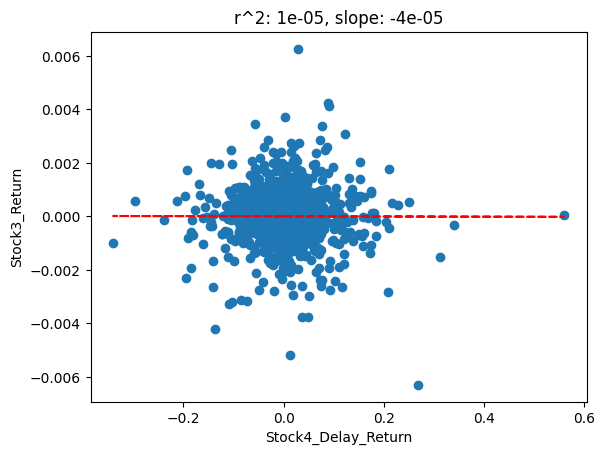

In [127]:
import matplotlib.pyplot as plt

for stock1 in ['Stock1_Delay_Return', 'Stock2_Delay_Return', 'Stock3_Delay_Return', 'Stock4_Delay_Return']:
    for stock2 in ['Stock1_Return', 'Stock2_Return', 'Stock3_Return', 'Stock4_Return']:
        if stock1[:6] != stock2[:6]:
            # # drop outliers
            # df = df[(np.abs(df[stock1] - df[stock1].mean()) <= (3 * df[stock1].std()))]
            # df = df[(np.abs(df[stock2] - df[stock2].mean()) <= (3 * df[stock2].std()))]
            # plot
            plt.scatter(df[stock1], df[stock2])
            plt.xlabel(stock1)
            plt.ylabel(stock2)
            # trend-line
            z = np.polyfit(df[stock1], df[stock2], 1)
            p = np.poly1d(z)
            plt.plot(df[stock1],p(df[stock1]),"r--")
            # set title to r^2 value, slope
            plt.title(f'r^2: {round(np.corrcoef(df[stock1], df[stock2])[0, 1] ** 2, 5)}, slope: {round(z[0], 5)}')
        plt.show()


In [128]:
from sklearn.model_selection import train_test_split

# 1 deg polynomial for stock 1, 2, 3, 4 onto each other
poly = PolynomialFeatures(degree=1)

# test each of the 3 stocks to predict the last one
delays = ['Stock1_Delay_Return', 'Stock2_Delay_Return', 'Stock3_Delay_Return', 'Stock4_Delay_Return']
labels = ['Stock1_Return', 'Stock2_Return', 'Stock3_Return', 'Stock4_Return']
for to_remove in range(len(delays)):
    X = poly.fit_transform(df[[delays[i] for i in range(len(delays)) if i != to_remove]])
    y = df[labels[to_remove]]
    X_train, X_test = train_test_split(X, test_size=0.2)
    y_train, y_test = train_test_split(y, test_size=0.2)
    model = LinearRegression()
    model.fit(X_train, y_train)
    print(f'Stock {to_remove + 1}:', model.score(X_train, y_train))
    print(f'Coefficients: {model.coef_}')

Stock 1: 0.0009771891305794256
Coefficients: [ 0.         -0.00434641 -0.01343935  0.00012101]
Stock 2: 0.005156946159913689
Coefficients: [ 0.00000000e+00 -2.05977100e-01 -3.97876623e-01 -1.80281420e-04]
Stock 3: 0.0033789684165990153
Coefficients: [ 0.         -0.05501965  0.0058861  -0.00017812]
Stock 4: 0.004163325930767847
Coefficients: [ 0.         -0.66522807 -0.49550393 -2.80931596]


In [129]:
# linear/polynomial models seem useless... let's try a random forest regressor

In [130]:
from sklearn.model_selection import train_test_split
# now do the exact same experiment but with a randon forest regressor
from sklearn.ensemble import RandomForestRegressor

# test each of the 3 stocks to predict the last one
delays = ['Stock1_Delay_Return', 'Stock2_Delay_Return', 'Stock3_Delay_Return', 'Stock4_Delay_Return']
labels = ['Stock1_Return', 'Stock2_Return', 'Stock3_Return', 'Stock4_Return']
for to_remove in range(len(delays)):
    # test train split
    X = df[[delays[i] for i in range(len(delays)) if i != to_remove]]
    X_train, X_test = train_test_split(X, test_size=0.2)
    y_train, y_test = train_test_split(df[labels[to_remove]], test_size=0.2)
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    print(f'Stock {to_remove + 1}:', model.score(X_test, y_test))
    print(f'Feature importances: {model.feature_importances_}')



Stock 1: -0.1899565262091305
Feature importances: [0.32773255 0.34385959 0.32840786]
Stock 2: -0.2976091300528243
Feature importances: [0.31859491 0.351255   0.33015009]
Stock 3: -0.04050636793415485
Feature importances: [0.31448259 0.32916764 0.35634977]
Stock 4: -0.17260947520685255
Feature importances: [0.30840366 0.34491153 0.34668481]


In [131]:
# much better!

#save forest
import pickle
for to_remove in range(len(delays)):
    X = df[[delays[i] for i in range(len(delays)) if i != to_remove]]
    y = df[labels[to_remove]]
    model = RandomForestRegressor()
    model.fit(X, y)
    filename = f'finalized_model{to_remove + 1}.sav'
    pickle.dump(model, open(filename, 'wb'))

# load model - usage
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)


In [132]:
# make pairplot of features
import seaborn as sns
# sns.pairplot(df[['Stock1_Delay_Return', 'Stock2_Delay_Return', 'Stock3_Delay_Return', 'Stock4_Delay_Return', 'Stock1_Return', 'Stock2_Return', 'Stock3_Return', 'Stock4_Return']])
# plt.show()



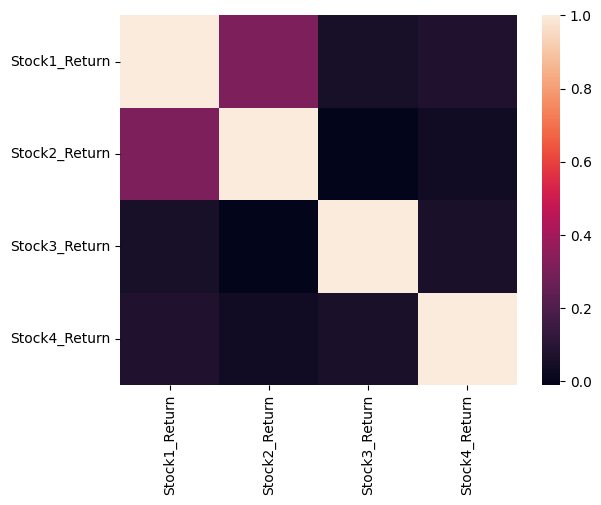

In [133]:



#find correlations between stocks
corr = df[['Stock1_Return', 'Stock2_Return', 'Stock3_Return', 'Stock4_Return']].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

In [134]:
# make graph to show how much each stock is correlated with the others and delayed data
# https://stackoverflow.com/questions/20224526/how-to-extract-the-diagonal-and-off-diagonal-part-of-a-matrix-in-numpy
# https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas

corr = df[['Stock1_Return', 'Stock2_Return', 'Stock3_Return', 'Stock4_Return']].corr()
corr = np.triu(corr)
corr = np.abs(corr)
corr = corr[corr != 0]
corr = corr[~np.isnan(corr)]
corr = corr[corr != 1]
corr = pd.DataFrame(corr)
corr = corr.sort_values(by=0, ascending=False)
corr = corr.rename(columns={0: 'corr'})
corr = corr.reset_index()
corr = corr.rename(columns={'index': 'pair'})
print(corr)

corr = df[['Stock1_Delay_Return', 'Stock2_Delay_Return', 'Stock3_Delay_Return', 'Stock4_Delay_Return']].corr()
corr = np.triu(corr)
corr = np.abs(corr)
corr = corr[corr != 0]
corr = corr[~np.isnan(corr)]
corr = corr[corr != 1]
corr = pd.DataFrame(corr)
corr = corr.sort_values(by=0, ascending=False)
corr = corr.rename(columns={0: 'corr'})
corr = corr.reset_index()
corr = corr.rename(columns={'index': 'pair'})
print(corr)

   pair      corr
0     0  0.312384
1     2  0.074108
2     5  0.059027
3     1  0.055727
4     4  0.036754
5     3  0.009530
   pair      corr
0     0  0.309000
1     2  0.072508
2     5  0.059755
3     1  0.056644
4     4  0.031846
5     3  0.007412


In [135]:
#predict  stock 1 with stock 2, 3, 4
from sklearn.model_selection import train_test_split

poly = PolynomialFeatures(degree=1)
delays = ['Stock2_Delay_Return', 'Stock3_Delay_Return', 'Stock4_Delay_Return']
X = poly.fit_transform(df[delays])
y = df['Stock1_Return']
X_train, X_test = train_test_split(X, test_size=0.2)
y_train, y_test = train_test_split(y, test_size=0.2)
model = LinearRegression()
model.fit(X_train, y_train)
print(f'Stock 1:', model.score(X_train, y_train))
print(f'Coefficients: {model.coef_}')



Stock 1: 0.004480768078667374
Coefficients: [ 0.         -0.00860285 -0.03881879  0.00038383]


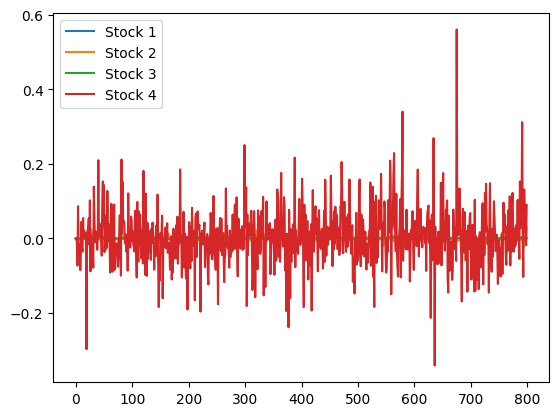

KeyError: 'ALIGNED'

In [144]:
#plot stocks over time
plt.plot(df['Stock1_Return'], label='Stock 1')



plt.plot(df['Stock2_Return'], label='Stock 2')
plt.plot(df['Stock3_Return'], label='Stock 3')
plt.plot(df['Stock4_Return'], label='Stock 4')
plt.legend()
plt.show()


#perform  trading strategy analysis on the stocks

# https://www.quantstart.com/articles/Backtesting-a-Trading-Strategy-with-Pandas-DataFrames
